# Парсер новостных текстов с сайтов РБК и Лента.ру

## Импорт библиотек и описание классов

In [1]:
# Установка библиотек
!pip install bs4
!pip install openpyxl

In [2]:
# Импорт библиотек
import requests as rq
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython import display

Ниже описаны классы для извлечения данных.

Используются поисковые движки сайтов, возвращающие по запросу json таблицы с информацией о статьях.

При их использовании есть различные ограничения, например, на количество статей в запросе. Так на сайте РБК выдается максимум 100 статей, в то время как на Ленте.ру можно получить сразу 1000. По моим наблюдениям, запросы на Лента.ру ограничены временем, и соответственно, точное ограничение найти не получится. Более того, на Лента.ру сразу выдается текст статьи в json таблице, с РБК приходится дополнительно парсить текст со страниц.  

### Парсер для Лента.ру

In [3]:
class lentaRu_parser:
    def __init__(self):
        pass

    def _get_url(self, param_dict: dict) -> str:
        """
        Возвращает URL для запроса json таблицы со статьями

        url = 'https://lenta.ru/search/v2/process?'\
        + 'from=0&'\                       # Смещение
        + 'size=1000&'\                    # Кол-во статей
        + 'sort=2&'\                       # Сортировка по дате (2), по релевантности (1)
        + 'title_only=0&'\                 # Точная фраза в заголовке
        + 'domain=1&'\                     # ??
        + 'modified%2Cformat=yyyy-MM-dd&'\ # Формат даты
        + 'type=1&'\                       # Материалы. Все материалы (0). Новость (1)
        + 'bloc=4&'\                       # Рубрика. Экономика (4). Все рубрики (0)
        + 'modified%2Cfrom=2020-01-01&'\
        + 'modified%2Cto=2020-11-01&'\
        + 'query='                         # Поисковой запрос
        """
        hasType = int(param_dict["type"]) != 0
        hasBloc = int(param_dict["bloc"]) != 0

        url = (
            "https://lenta.ru/search/v2/process?"
            + "from={}&".format(param_dict["from"])
            + "size={}&".format(param_dict["size"])
            + "sort={}&".format(param_dict["sort"])
            + "title_only={}&".format(param_dict["title_only"])
            + "domain={}&".format(param_dict["domain"])
            + "modified%2Cformat=yyyy-MM-dd&"
            + "type={}&".format(param_dict["type"]) * hasType
            + "bloc={}&".format(param_dict["bloc"]) * hasBloc
            + "modified%2Cfrom={}&".format(param_dict["dateFrom"])
            + "modified%2Cto={}&".format(param_dict["dateTo"])
            + "query={}".format(param_dict["query"])
        )

        return url

    def _get_search_table(self, param_dict: dict) -> pd.DataFrame:
        """
        Возвращает pd.DataFrame со списком статей
        """
        url = self._get_url(param_dict)
        r = rq.get(url)
        search_table = pd.DataFrame(r.json()["matches"])

        return search_table

    def get_articles(
        self, param_dict, time_step=37, save_every=5, save_excel=True
    ) -> pd.DataFrame:
        """
        Функция для скачивания статей интервалами через каждые time_step дней
        Делает сохранение таблицы через каждые save_every * time_step дней

        param_dict: dict
        ### Параметры запроса
        ###### project - раздел поиска, например, rbcnews
        ###### category - категория поиска, например, TopRbcRu_economics
        ###### dateFrom - с даты
        ###### dateTo - по дату
        ###### offset - смещение поисковой выдачи
        ###### limit - лимит статей, максимум 100
        ###### query - поисковой запрос (ключевое слово), например, РБК

        """
        param_copy = param_dict.copy()
        time_step = timedelta(days=time_step)
        dateFrom = datetime.strptime(param_copy["dateFrom"], "%Y-%m-%d")
        dateTo = datetime.strptime(param_copy["dateTo"], "%Y-%m-%d")
        if dateFrom > dateTo:
            raise ValueError("dateFrom should be less than dateTo")

        out = pd.DataFrame()
        save_counter = 0

        while dateFrom <= dateTo:
            param_copy["dateTo"] = (dateFrom + time_step).strftime("%Y-%m-%d")
            if dateFrom + time_step > dateTo:
                param_copy["dateTo"] = dateTo.strftime("%Y-%m-%d")
            print(
                "Parsing articles from "
                + param_copy["dateFrom"]
                + " to "
                + param_copy["dateTo"]
            )
            out = out.append(self._get_search_table(param_copy), ignore_index=True)
            dateFrom += time_step + timedelta(days=1)
            param_copy["dateFrom"] = dateFrom.strftime("%Y-%m-%d")
            save_counter += 1
            if save_counter == save_every:
                display.clear_output(wait=True)
                out.to_excel("/tmp/checkpoint_table.xlsx")
                print("Checkpoint saved!")
                save_counter = 0

        if save_excel:
            out.to_excel(
                "lenta_{}_{}.xlsx".format(param_dict["dateFrom"], param_dict["dateTo"])
            )
        print("Finish")

        return out

## Пример выгрузки данных

### Лента.ру

* __query__ - поисковой запрос (ключевое слово)

* __offset__ - cмещение поисковой выдачи (от 0 до __size__)

* __size__ - количество статей. Ограничено время запроса, точного лимита нет. 1000 работает почти всегда

* __sort__ - сортировка по дате: (2) - по убыванию, (3) - по возрастанию; по релевантности (1)

* __title_only__ - точная фраза в заголовке (1)

* __domain__ - ?

* __material__ - материалы: Все материалы (0). Новость (1). ["0", "1", "2", "3", "4", ...]

* __block__ - рубрика: Экономика (4). Все рубрики (0). ["0", "1", "2", "3", "4", ...]

* __dateFrom__ - с даты

* __dateTo__ - по дату

_Чтобы не специфировать параметр, оставляем поле пустым_

In [4]:
# Задаем тут параметры
use_parser = "LentaRu"

query = ""
offset = 0
size = 1000
sort = "3"
title_only = "0"
domain = "1"
material = "0"
bloc = "0"
dateFrom = "2023-01-01"
dateTo = "2023-10-21"

if use_parser == "LentaRu":
    param_dict = {
        "query": query,
        "from": str(offset),
        "size": str(size),
        "dateFrom": dateFrom,
        "dateTo": dateTo,
        "sort": sort,
        "title_only": title_only,
        "type": material,
        "bloc": bloc,
        "domain": domain,
    }

print(use_parser, "- param_dict:", param_dict)

LentaRu - param_dict: {'query': '', 'from': '0', 'size': '1000', 'dateFrom': '2023-01-01', 'dateTo': '2023-10-21', 'sort': '3', 'title_only': '0', 'type': '0', 'bloc': '0', 'domain': '1'}


In [5]:
# Тоже будем собирать итеративно, правда можно ставить time_step побольше, т.к.
# больше лимит на запрос статей. И Работает быстрее :)
assert use_parser == "LentaRu"
parser = lentaRu_parser()
tbl = parser.get_articles(
    param_dict=param_dict, time_step=37, save_every=5, save_excel=True
)
print(len(tbl.index))

Checkpoint saved!
Parsing articles from 2023-07-10 to 2023-08-16


<ipython-input-3-289857848482>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  out = out.append(self._get_search_table(param_copy), ignore_index=True)


Parsing articles from 2023-08-17 to 2023-09-23


<ipython-input-3-289857848482>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  out = out.append(self._get_search_table(param_copy), ignore_index=True)


Parsing articles from 2023-09-24 to 2023-10-21


<ipython-input-3-289857848482>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  out = out.append(self._get_search_table(param_copy), ignore_index=True)


Finish
8000


In [6]:
print(f"shape tbl{tbl.shape}")
print(f"unique categories {tbl.bloc.unique()}")

shape tbl(8000, 16)
unique categories [ 2  1 12  5  8  4 87  0 48  3 37  6  7  9 86 47 49 11]


In [7]:
tbl.groupby("bloc").agg({"docid": "count"})

,docid
bloc,
0,107
1,1554
2,1502
3,880
4,686
5,351
6,253
7,278
8,557


In [8]:
news_category = {1: "russia_news", 2: "world", 3: "former_ussr", 4: "economy"}

In [9]:
tbl.loc[tbl.bloc.isin([1, 2, 3, 4])].groupby("bloc").agg({"docid": "count"})

,docid
bloc,
1,1554
2,1502
3,880
4,686


In [10]:
df = tbl.loc[tbl.bloc.isin([1, 2, 3, 4])]

In [11]:
df.head(2)

,docid,url,title,modified,lastmodtime,type,domain,status,part,bloc,tags,image_url,pubdate,text,rightcol,snippet
0,1363803,https://lenta.ru/news/2023/01/01/exponenta/,Ким Чен Ын пообещал нарастить производство яде...,1672531825,1672531825,1,1,0,0,2,[1],https://icdn.lenta.ru/images/2023/01/01/03/202...,1672531825,Фото: ЦТАК / Reuters Марина Совина Лидер КНДР ...,Ким Чен Ын пообещал нарастить производство яде...,Фото: ЦТАК / Reuters Марина Совина Лидер ... я...
1,1363805,https://lenta.ru/news/2023/01/01/yaroslavl/,В российском городе пропал ребенок,1672532081,1672532081,1,1,0,0,1,[4],https://icdn.lenta.ru/images/2023/01/01/03/202...,1672532081,Фото: Кирилл Шипицин / РИА Новости Марина Сови...,В российском городе пропал ребенок,Фото: Кирилл Шипицин / РИА Новости ... мальчик...


In [12]:
df.to_csv("lenta_news", index=False)

In [13]:
df = pd.read_csv("lenta_news")

In [14]:
df.columns

Index(['docid', 'url', 'title', 'modified', 'lastmodtime', 'type', 'domain',
       'status', 'part', 'bloc', 'tags', 'image_url', 'pubdate', 'text',
       'rightcol', 'snippet'],
      dtype='object')

In [15]:
# Еще раз зададим словарь с типами новостей
news_category = {1: "russia_news", 2: "world", 3: "former_ussr", 4: "economy"}

In [16]:
# Дропиним столбцы, которые мы не будем использовать
df.drop(
    columns=[
        "docid",
        "modified",
        "lastmodtime",
        "type",
        "domain",
        "status",
        "part",
        "tags",
        "image_url",
        "rightcol",
    ],
    inplace=True,
)

# Подтянем категории новостей из словаря
df.bloc = df.bloc.map(news_category)

# Заменем названия колонок на более читаемое
df.rename(
    columns={"text": "content", "snippet": "subtitle", "bloc": "topic"}, inplace=True
)

# Переведем timestamp в стринг с датой и временем
df["pubdate"] = df["pubdate"].apply(lambda x: str(datetime.fromtimestamp(x)))

# Переименуем столбец содержащий дату и время
df.rename(columns={"pubdate": "datetime"}, inplace=True)

In [17]:
df.head(2)

,url,title,topic,datetime,content,subtitle
0,https://lenta.ru/news/2023/01/01/exponenta/,Ким Чен Ын пообещал нарастить производство яде...,world,2023-01-01 00:10:25,Фото: ЦТАК / Reuters Марина Совина Лидер КНДР ...,Фото: ЦТАК / Reuters Марина Совина Лидер ... я...
1,https://lenta.ru/news/2023/01/01/yaroslavl/,В российском городе пропал ребенок,russia_news,2023-01-01 00:14:41,Фото: Кирилл Шипицин / РИА Новости Марина Сови...,Фото: Кирилл Шипицин / РИА Новости ... мальчик...


In [18]:
df.columns

Index(['url', 'title', 'topic', 'datetime', 'content', 'subtitle'], dtype='object')

In [19]:
df = df[["url", "title", "subtitle", "datetime", "content", "topic"]]

In [20]:
df.shape

(4622, 6)

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")

sns.set(style="darkgrid")
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


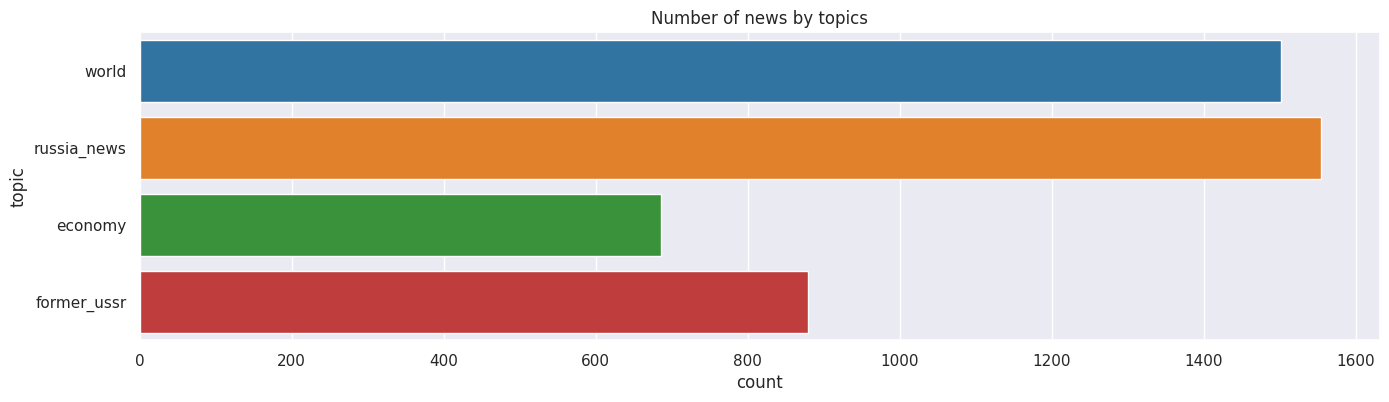

In [22]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(16, 4))
sns.countplot(y=df["topic"], palette="tab10", ax=ax)
plt.title("Number of news by topics");

Видим, что в часть категорий несбалансированы. Это не удивительно, поскольку мы настроили парсер именно так, чтобы выгружать все статьи за определенный период времени. В нашем случае - это 23 год.

In [23]:
df["len_title"] = df["title"].str.len()
df["len_subtitle"] = df["subtitle"].str.len()
df["len_content"] = df["content"].str.len()

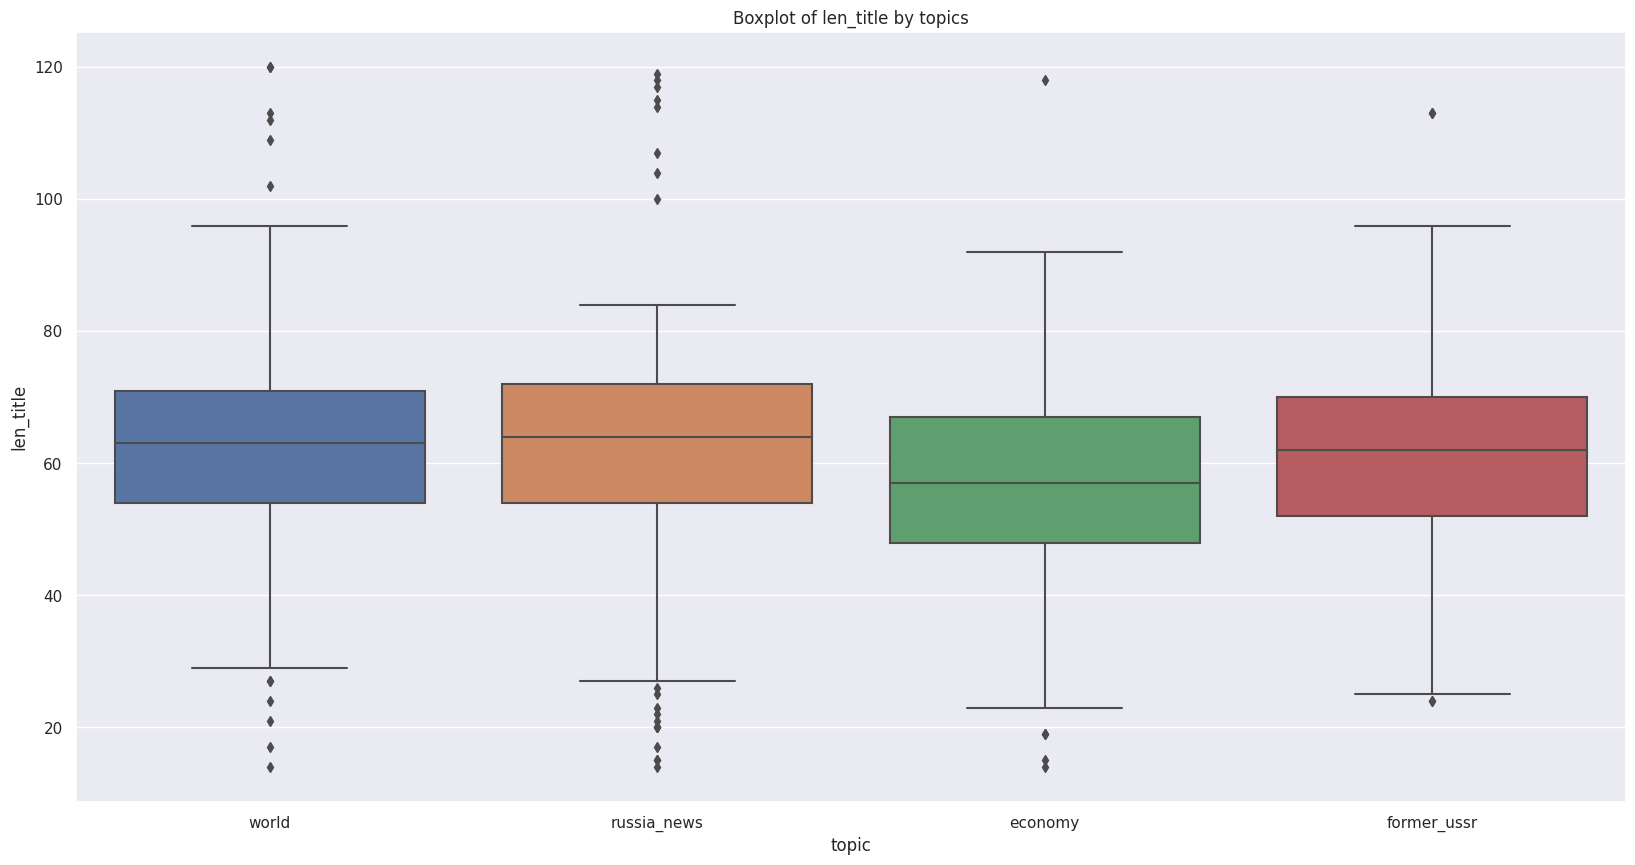

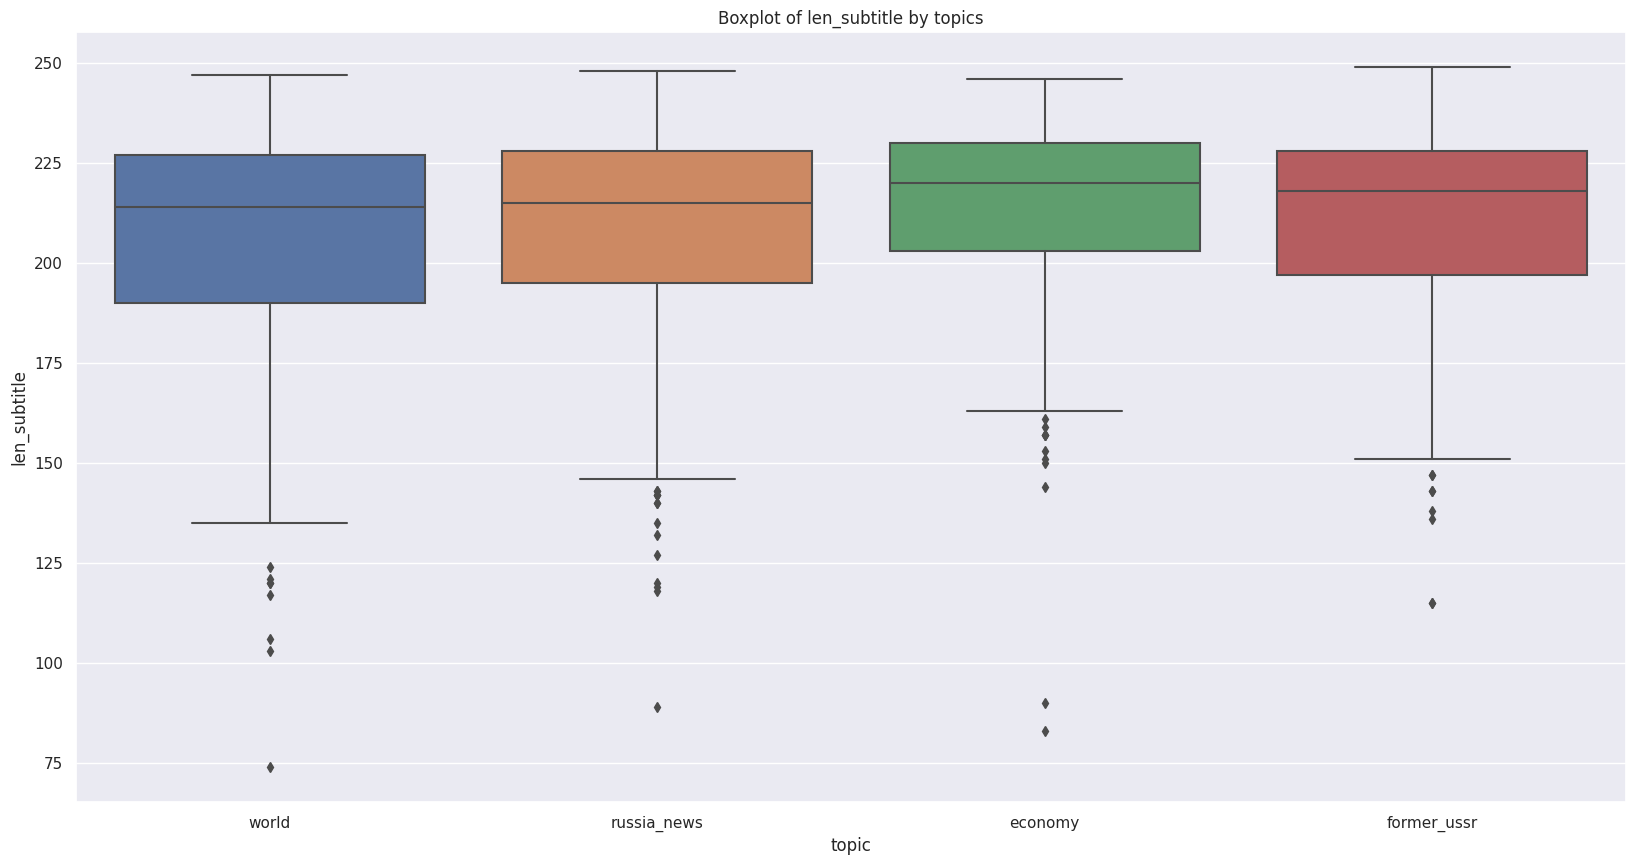

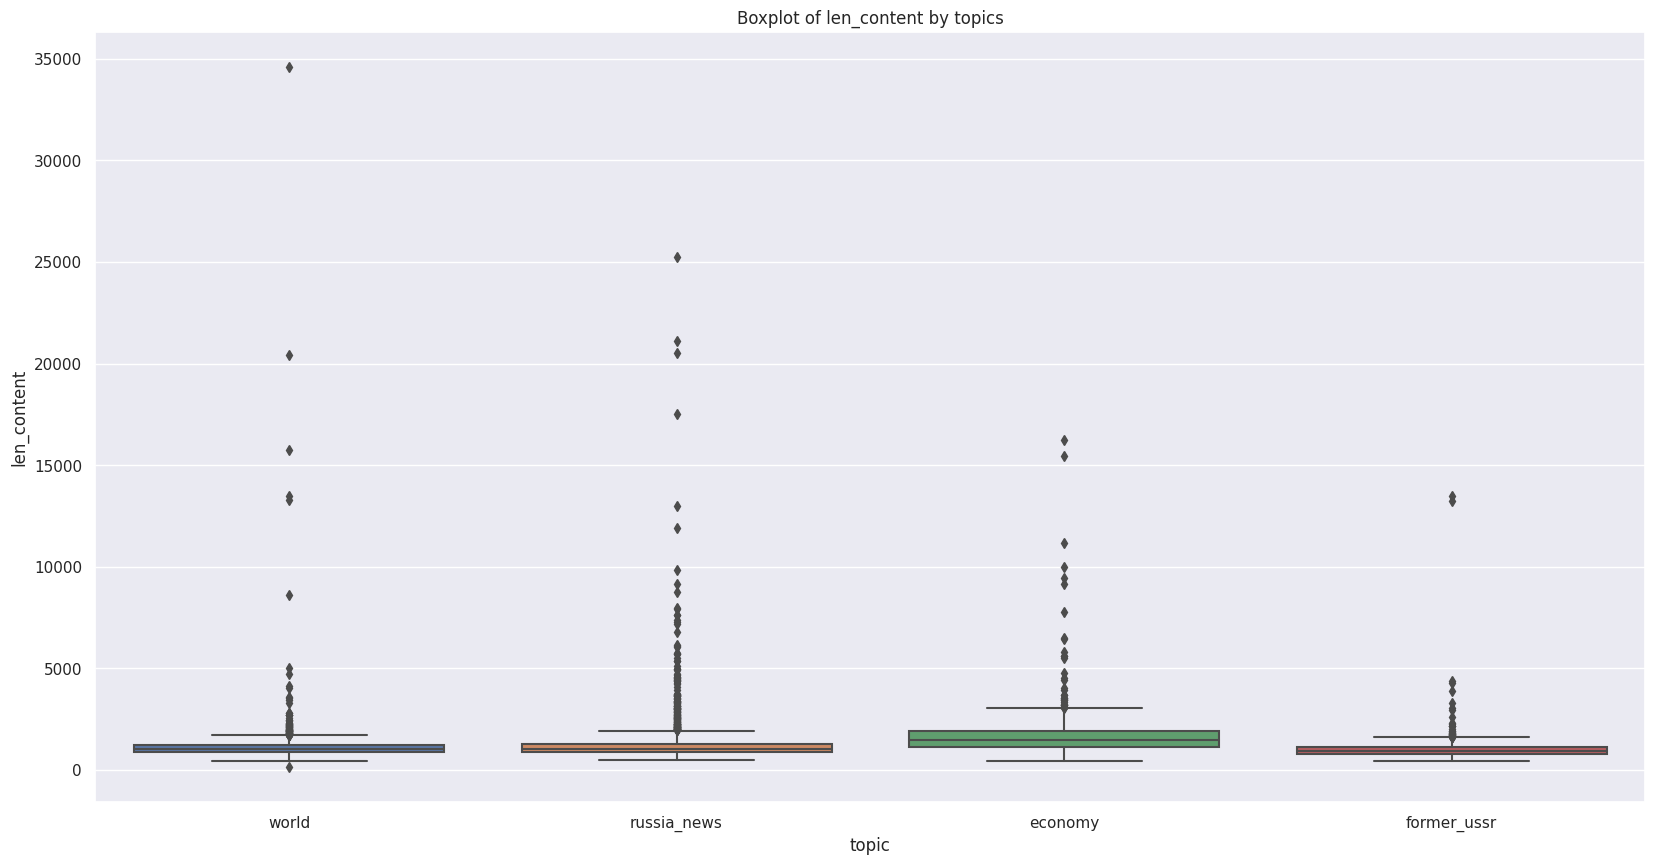

In [24]:
for col in ["len_title", "len_subtitle", "len_content"]:
    fig, ax = plt.subplots(1, 1, figsize=(20, 10), dpi=100)
    sns.boxplot(x="topic", y=col, data=df, ax=ax)
    plt.title(f"Boxplot of {col} by topics");

Что можно заметить:
- В среднем длина заголовка по всем категориям около 65 - 70 символов
- В среднем длина подзаголовка состовляет 220 символов
- Длина текста имеет тяжелые хвосты, особенно по категориям: 'russia_news'

In [25]:
stop_words = stopwords.words("russian")
stop_words.extend(
    [
        "что",
        "это",
        "так",
        "вот",
        "быть",
        "как",
        "в",
        "—",
        "к",
        "за",
        "из",
        "из-за",
        "на",
        "ок",
        "кстати",
        "который",
        "мочь",
        "весь",
        "еще",
        "также",
        "свой",
        "ещё",
        "самый",
        "ул",
        "комментарий",
        "английский",
        "язык",
    ]
)

In [26]:
for topic in df.topic.unique():
    words = df[df.topic == topic].title.str.split(" ").explode().values
    words = [word.lower() for word in words if word.lower() not in stop_words]

    wc = WordCloud(background_color="black", width=1600, height=800)
    wc.generate(" ".join(words))

    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    plt.axis("off")
    plt.tight_layout(pad=0)
    ax.set_title(f"Frequent words in {topic} topic", fontsize=30)
    ax.imshow(wc, alpha=0.98)

In [27]:
df.columns

Index(['url', 'title', 'subtitle', 'datetime', 'content', 'topic', 'len_title',
       'len_subtitle', 'len_content'],
      dtype='object')

In [31]:
df["datetime"] = pd.to_datetime(df.datetime)
df["month"] = df["datetime"].dt.strftime("%B")
df["weekday"] = df["datetime"].dt.strftime("%A")

In [33]:
df.head(2)

,url,title,subtitle,datetime,content,topic,len_title,len_subtitle,len_content,month,weekday
0,https://lenta.ru/news/2023/01/01/exponenta/,Ким Чен Ын пообещал нарастить производство яде...,Фото: ЦТАК / Reuters Марина Совина Лидер ... я...,2023-01-01 00:10:25,Фото: ЦТАК / Reuters Марина Совина Лидер КНДР ...,world,77,219.0,932.0,January,Sunday
1,https://lenta.ru/news/2023/01/01/yaroslavl/,В российском городе пропал ребенок,Фото: Кирилл Шипицин / РИА Новости ... мальчик...,2023-01-01 00:14:41,Фото: Кирилл Шипицин / РИА Новости Марина Сови...,russia_news,34,143.0,709.0,January,Sunday


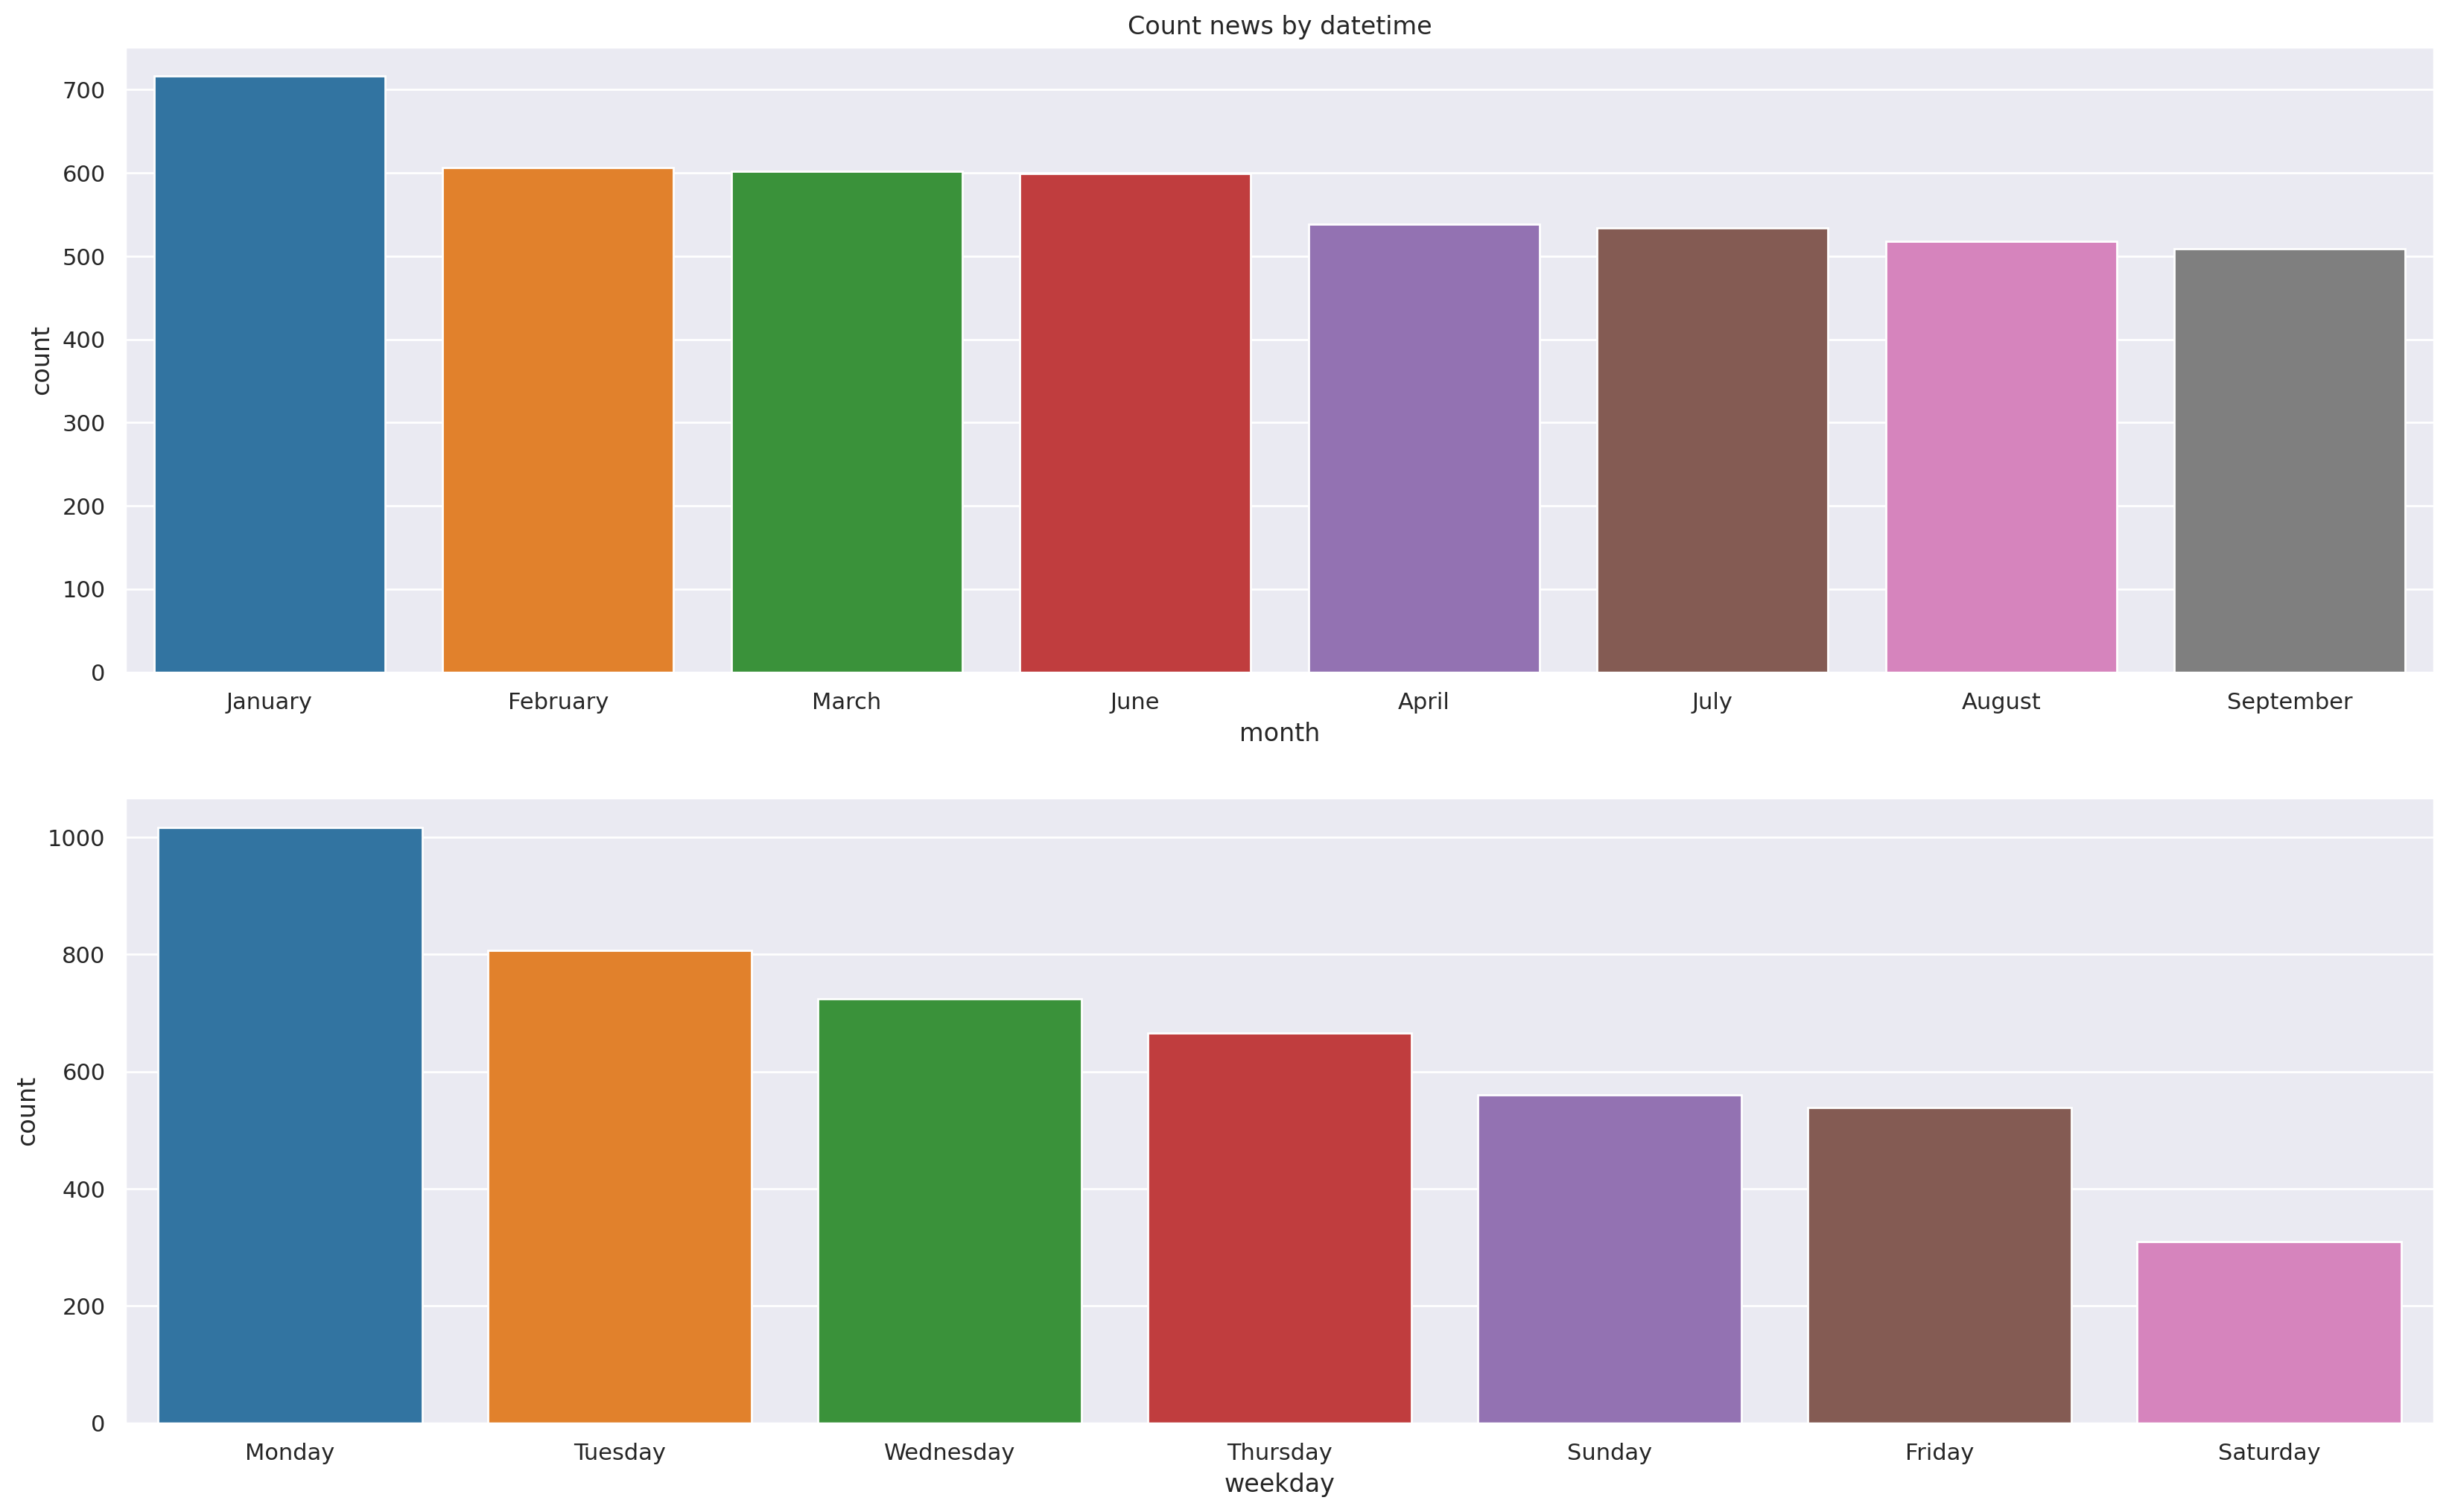

In [37]:
fig, axs = plt.subplots(2, 1, figsize=(20, 12), dpi=200)
for ind, col in enumerate(["month", "weekday"]):
    sns.countplot(
        x=df[col],
        palette="tab10",
        ax=axs[ind],
        order=df[col].value_counts(ascending=False).index,
    )
axs[0].set_title("Count news by datetime");

- В целом заметно падение количества статей по году.
- В течение недели, к конуц недели на статье выходит меньше статей.

### Выводы

Итак, на данном этапе мы провели первичный анализ датасета. Статьи распределены по тематикам достаточно равномерно. Все новости относятся к 2023 году, а больше всего новостей в январе и феврале. Меньше всего новостей выходит в выходные и больше всего в первый и второй рабочие дни недели - понедельник и вторник.

У всех статей есть подзаголовокВ среднем длина заголовка по всем категориям около 65 - 70 символов. Длина текста имеет тяжелые хвосты, особенно по категориям 'russia_news'.

Мы также проанализировали основные ключевые слова, которые наводят на гипотезу о том, что статьи разных тематик могут быть сильно похожи по доминирующим ключевым словам и тем самым негативно влиять на модель. Это нужно будет иметь в виду при построоении модели.

Поскольку мы работаем с текстами, на этом этапе пока не столь очевидно, какие данные и по какой причине стоит считать выбросами, а какие - особенностями конкретной тематики. Поэтому это мы оставим на следующие этапы работы над проектом.